In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('dataset_final.csv')
df.head()

,Province/State,04/02/2020,04/03/2020,04/04/2020,04/05/2020,04/06/2020,04/07/2020,04/08/2020,04/09/2020,04/10/2020,...,10/04/20,10/05/20,10/06/20,10/07/20,10/08/20,10/09/20,10/10/20,10/11/20,10/12/20,10/13/20
0,AB,13,15,33,34,50,83,90,100,103,...,2042,2095,2212,2283,2389,2504,2578,2630,2731,2862
1,AR,110,128,150,157,161,161,162,179,229,...,2852,2892,2972,3040,3091,3166,3208,3256,3305,3423
2,AG,12,14,25,27,31,33,32,52,51,...,5601,5621,5666,5715,5749,5767,5789,5806,5835,5893
3,BC,24,27,38,39,47,51,56,58,65,...,4964,5048,5130,5280,5459,5549,5712,5811,5967,6052
4,BH,44,46,46,52,55,58,66,70,83,...,3752,3800,3839,3904,3965,4011,4047,4088,4152,4248


In [5]:
df = df.iloc[:,1:]

In [6]:
df.head()

,04/02/2020,04/03/2020,04/04/2020,04/05/2020,04/06/2020,04/07/2020,04/08/2020,04/09/2020,04/10/2020,04/11/2020,...,10/04/20,10/05/20,10/06/20,10/07/20,10/08/20,10/09/20,10/10/20,10/11/20,10/12/20,10/13/20
0,13,15,33,34,50,83,90,100,103,108,...,2042,2095,2212,2283,2389,2504,2578,2630,2731,2862
1,110,128,150,157,161,161,162,179,229,249,...,2852,2892,2972,3040,3091,3166,3208,3256,3305,3423
2,12,14,25,27,31,33,32,52,51,57,...,5601,5621,5666,5715,5749,5767,5789,5806,5835,5893
3,24,27,38,39,47,51,56,58,65,69,...,4964,5048,5130,5280,5459,5549,5712,5811,5967,6052
4,44,46,46,52,55,58,66,70,83,83,...,3752,3800,3839,3904,3965,4011,4047,4088,4152,4248


In [7]:
df.isnull().sum().sum()

0

In [8]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-04-02    3183
2020-04-03    3388
2020-04-04    3864
2020-04-05    4057
2020-04-06    4417
dtype: int64

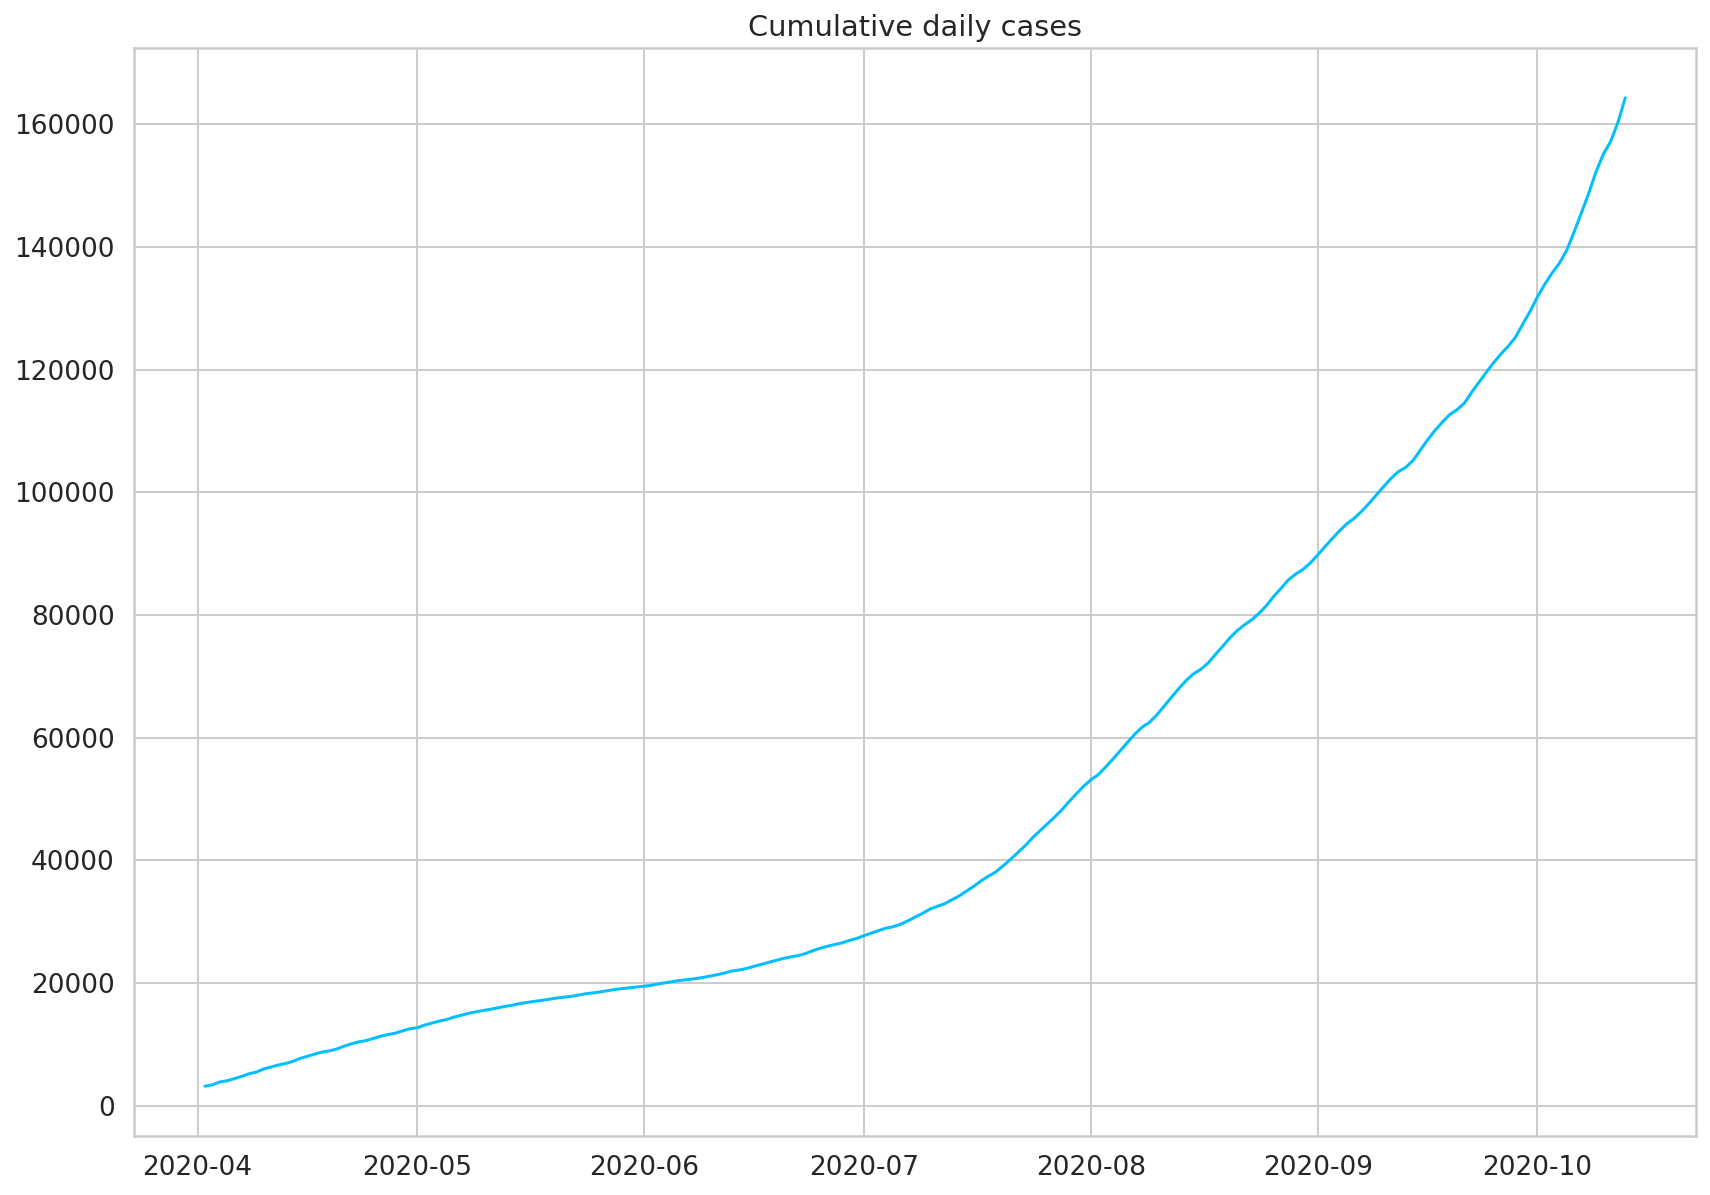

In [9]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [10]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-04-02    3183
2020-04-03     205
2020-04-04     476
2020-04-05     193
2020-04-06     360
dtype: int64

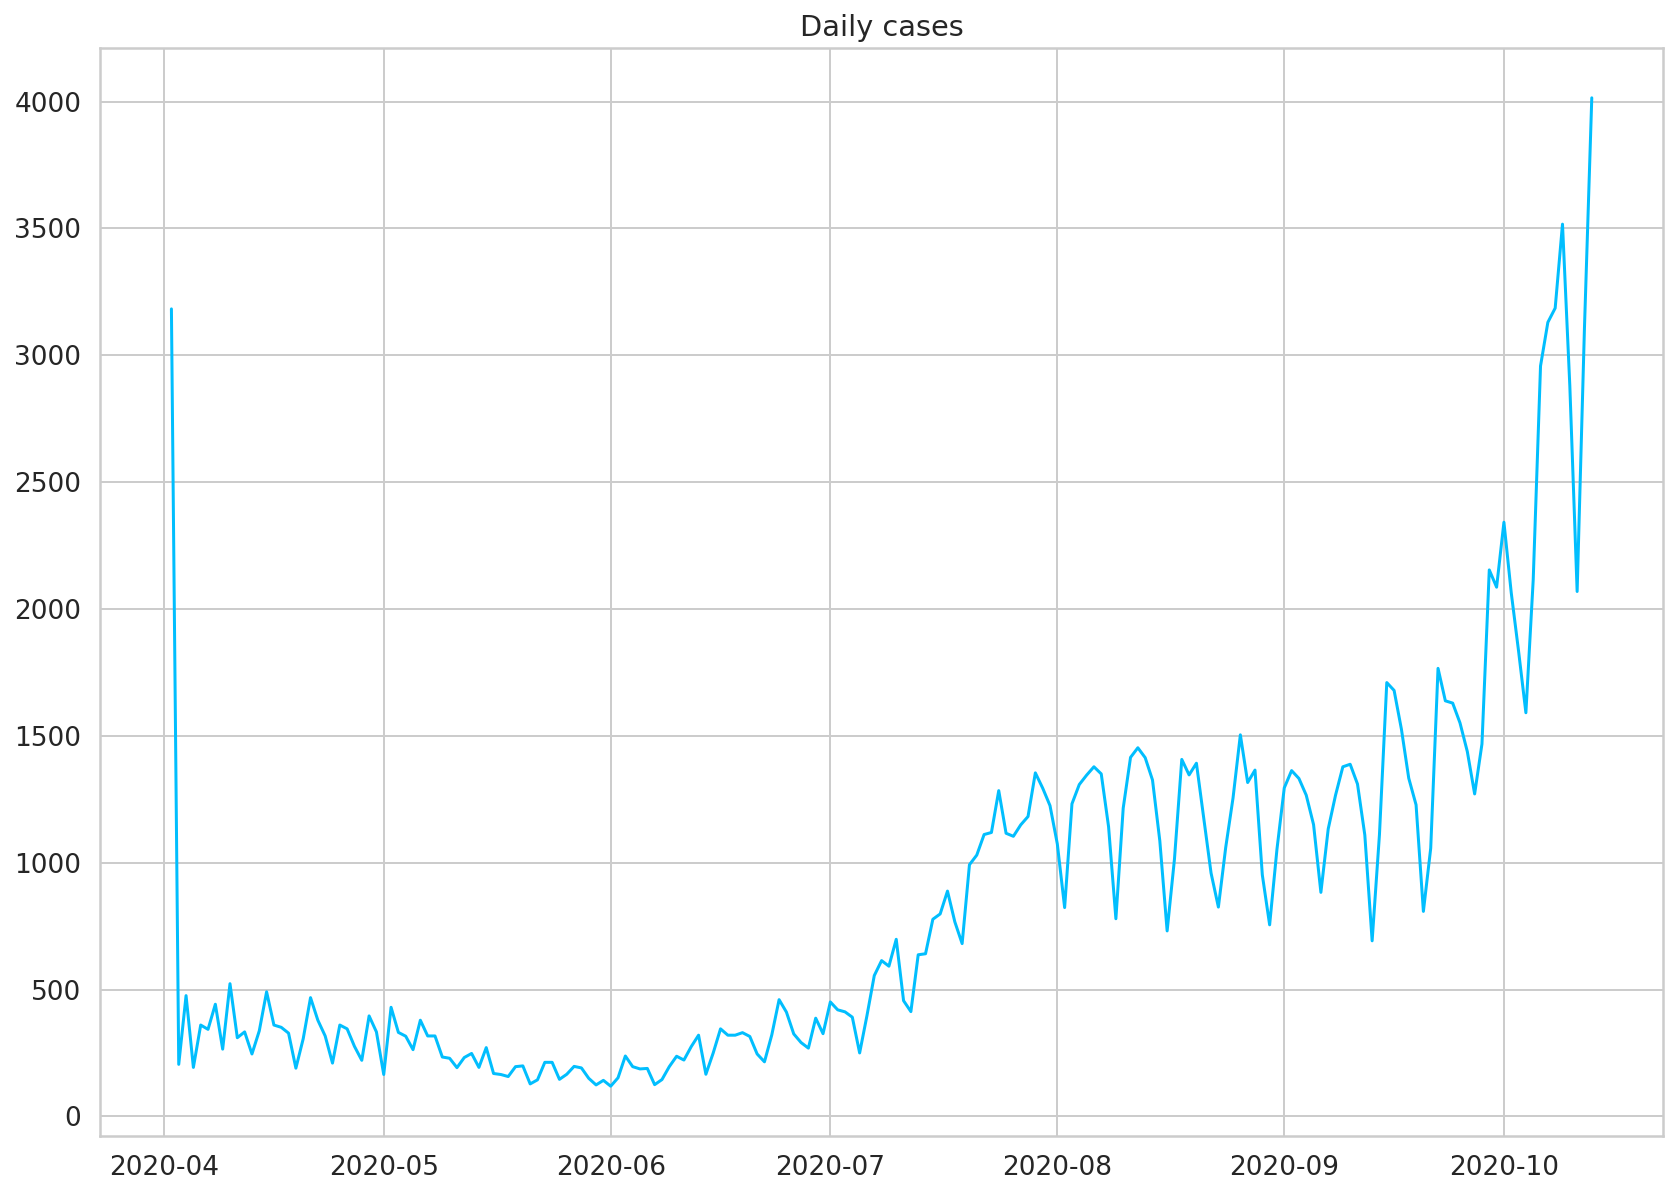

In [11]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [12]:
daily_cases.shape

(195,)

In [13]:
test_data_size = 39

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(156,)

In [14]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

print(test_data)

[[0.33648825]
 [0.24934726]
 [0.33093995]
 [0.37434726]
 [0.41090078]
 [0.41416449]
 [0.38870757]
 [0.32310705]
 [0.18701044]
 [0.32375979]
 [0.51925587]
 [0.50913838]
 [0.45920366]
 [0.3962141 ]
 [0.36194517]
 [0.22486945]
 [0.30613577]
 [0.53753264]
 [0.49575718]
 [0.49281984]
 [0.46736292]
 [0.43048303]
 [0.37597911]
 [0.44027415]
 [0.66416449]
 [0.64197128]
 [0.72552219]
 [0.63479112]
 [0.55972585]
 [0.48041775]
 [0.65143603]
 [0.92656658]
 [0.98270235]
 [1.00097911]
 [1.10900783]
 [0.90110966]
 [0.63642298]
 [0.97584856]
 [1.27154047]]


In [15]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [16]:
seq_length = 23
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [17]:
X_train.shape

torch.Size([132, 23, 1])

In [18]:
X_train[:2]

tensor([[[1.0000],
         [0.0281],
         [0.1165],
         [0.0242],
         [0.0787],
         [0.0731],
         [0.1054],
         [0.0477],
         [0.1319],
         [0.0623],
         [0.0698],
         [0.0414],
         [0.0711],
         [0.1214],
         [0.0787],
         [0.0757],
         [0.0682],
         [0.0232],
         [0.0610],
         [0.1139],
         [0.0849],
         [0.0646],
         [0.0297]],

        [[0.0281],
         [0.1165],
         [0.0242],
         [0.0787],
         [0.0731],
         [0.1054],
         [0.0477],
         [0.1319],
         [0.0623],
         [0.0698],
         [0.0414],
         [0.0711],
         [0.1214],
         [0.0787],
         [0.0757],
         [0.0682],
         [0.0232],
         [0.0610],
         [0.1139],
         [0.0849],
         [0.0646],
         [0.0297],
         [0.0787]]])

In [19]:
y_train.shape

torch.Size([132, 1])

In [20]:
y_train[:2]

tensor([[0.0787],
        [0.0738]])

In [21]:
train_data[:10]

array([[1.        ],
       [0.02806789],
       [0.11651436],
       [0.02415144],
       [0.07865535],
       [0.07310705],
       [0.10541775],
       [0.04765013],
       [0.13185379],
       [0.06233681]])

In [22]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [31]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 50

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [24]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 5.680553436279297 test loss: 8.815473556518555
Epoch 10 train loss: 2.903743028640747 test loss: 6.235313415527344
Epoch 20 train loss: 2.844594717025757 test loss: 5.876781940460205
Epoch 30 train loss: 2.8389248847961426 test loss: 5.879809379577637
Epoch 40 train loss: 2.8370819091796875 test loss: 5.862653732299805
Epoch 50 train loss: 2.832850933074951 test loss: 5.885368824005127
Epoch 60 train loss: 2.831195116043091 test loss: 5.9276533126831055
Epoch 70 train loss: 2.8368518352508545 test loss: 5.936225891113281
Epoch 80 train loss: 2.843310594558716 test loss: 6.024713039398193
Epoch 90 train loss: 2.8430593013763428 test loss: 6.092115879058838
Epoch 100 train loss: 2.8423261642456055 test loss: 6.041325569152832
Epoch 110 train loss: 2.807969331741333 test loss: 6.192239284515381
Epoch 120 train loss: 2.813237190246582 test loss: 6.33766508102417
Epoch 130 train loss: 2.818702459335327 test loss: 6.586228370666504
Epoch 140 train loss: 2.7660412788391113

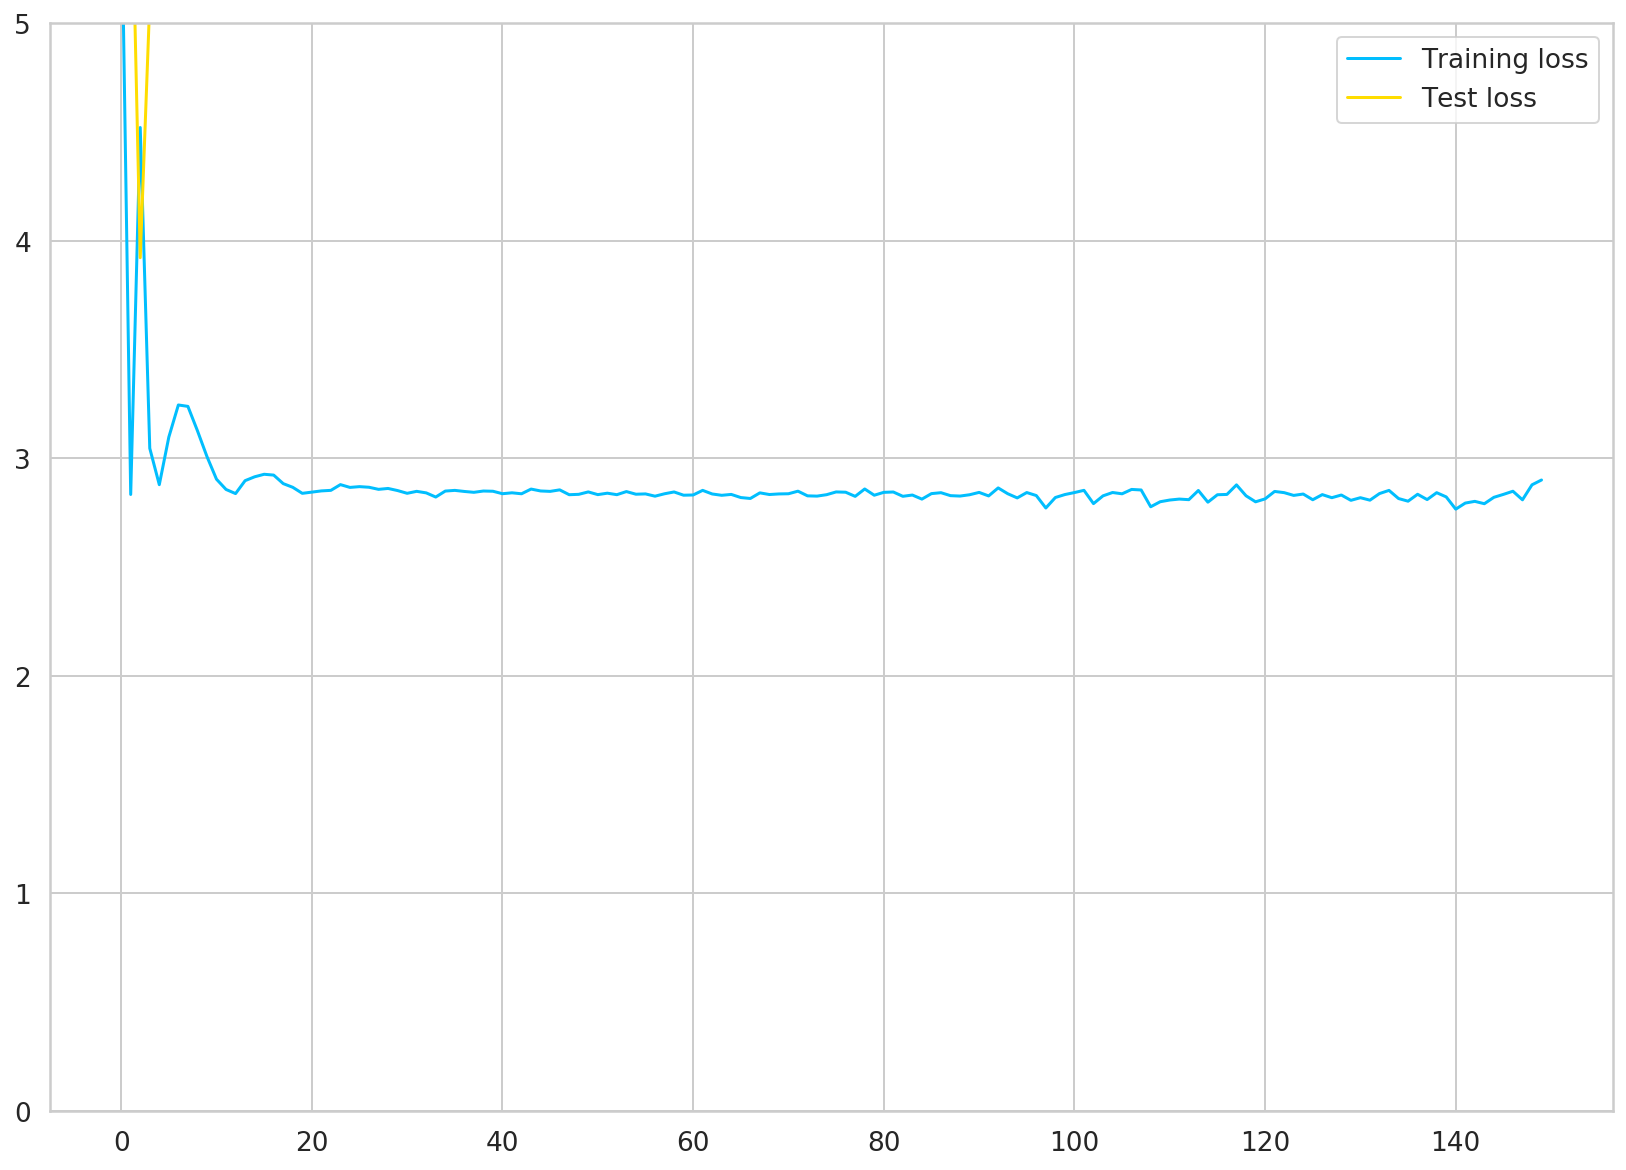

In [25]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [32]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [33]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

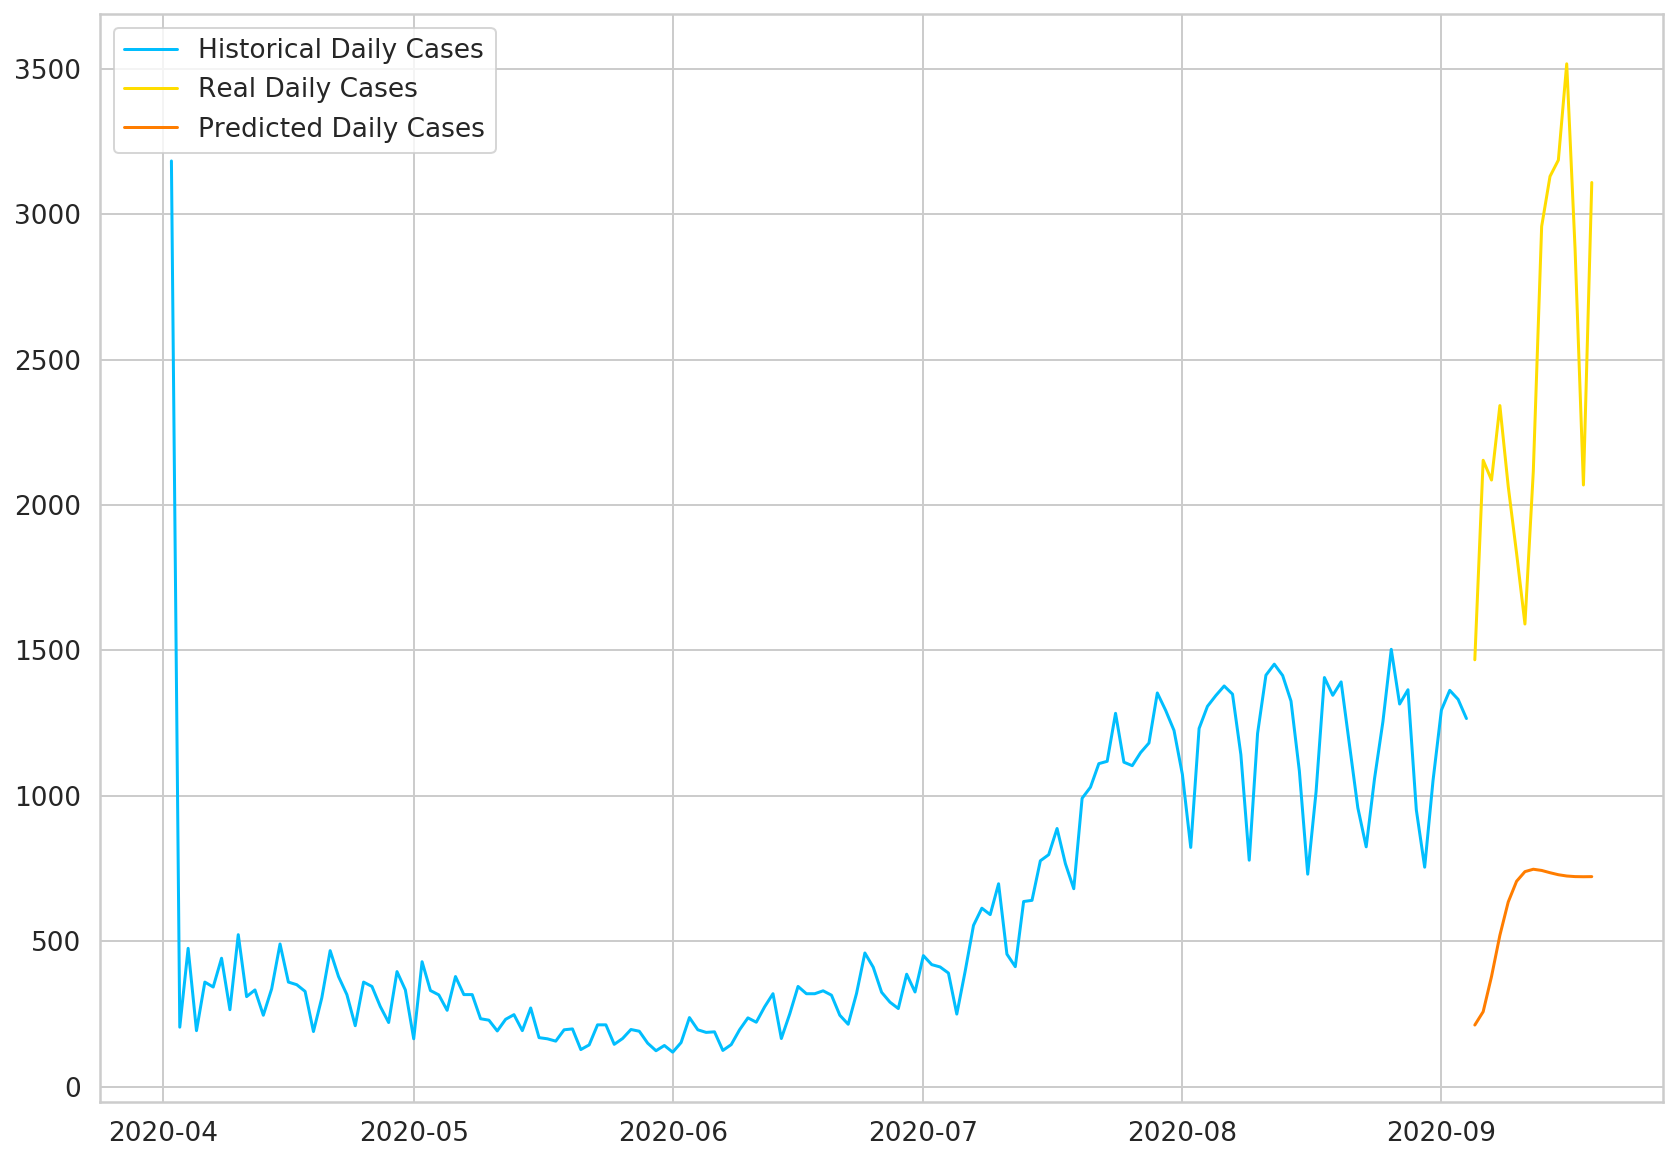

In [28]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [34]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(195, 1)

In [35]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 6.87418794631958
Epoch 10 train loss: 2.963874101638794
Epoch 20 train loss: 2.842942953109741
Epoch 30 train loss: 2.836564064025879
Epoch 40 train loss: 2.8383967876434326


In [47]:
DAYS_TO_PREDICT = 60

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [48]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [49]:
daily_cases.index[-1]

Timestamp('2020-10-13 00:00:00')

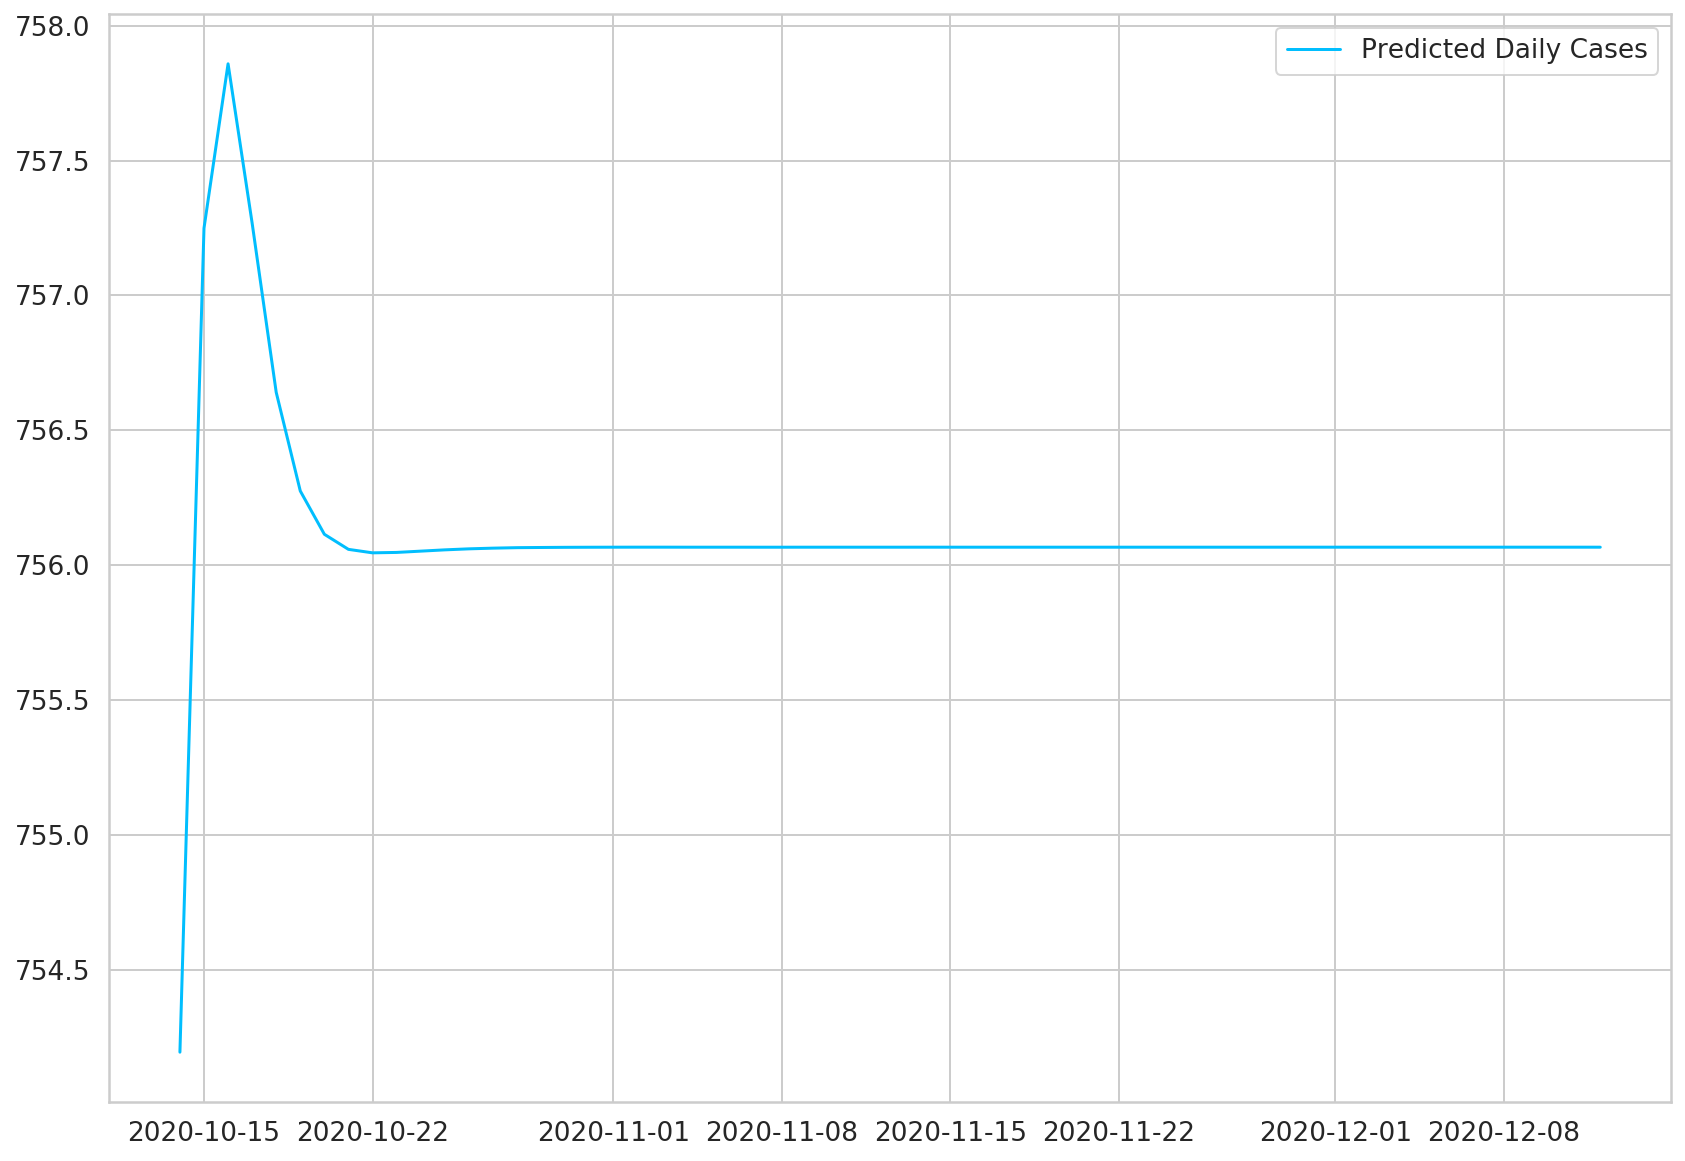

In [50]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

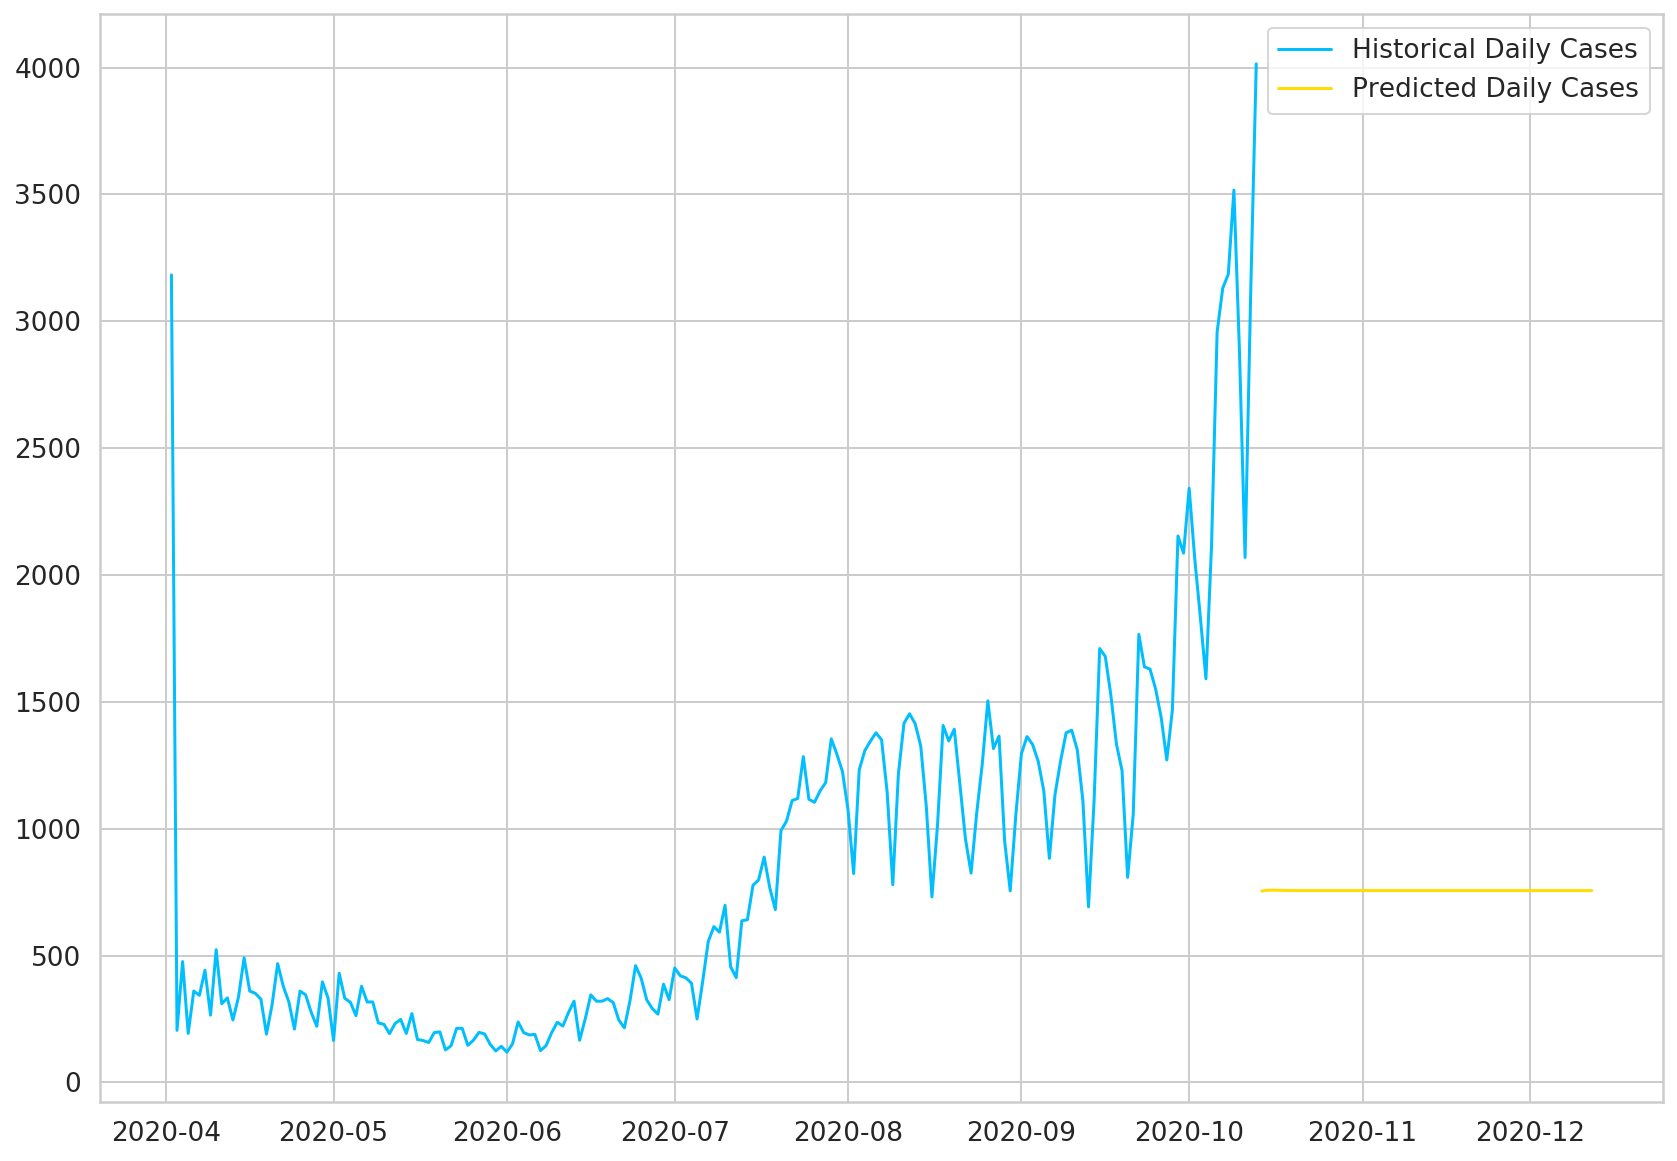

In [51]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();